<a href="https://colab.research.google.com/github/bharathbolla/EIP4/blob/assignment_4/EIP4_Phase1_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 14s 0us/step


In [6]:
import keras
#print(tf.__version__)
print(keras.__version__)

2.2.5


In [7]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=3916b8adecdafc0b1fea50ce007726b1d796a54af162ca54fa5d87df6029f5eb
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

In [9]:
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 12.5 GB  | Proc size: 616.0 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


In [10]:
!nvidia-smi

Sun Dec  8 10:28:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [15]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 28s 73ms/step - loss: 1.5552 - acc: 0.5004 - val_loss: 2.0566 - val_acc: 0.4202
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 22s 57ms/step - loss: 1.0694 - acc: 0.6758 - val_loss: 1.9904 - val_acc: 0.4951
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 23s 58ms/step - loss: 0.8825 - acc: 0.7455 - val_loss: 1.1574 - val_acc: 0.6599
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 23s 58ms/step - loss: 0.7663 - acc: 0.7864 - val_loss: 1.0114 - val_acc: 0.7136
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 22s 57ms/step - loss: 0.6754 - acc: 0.8200

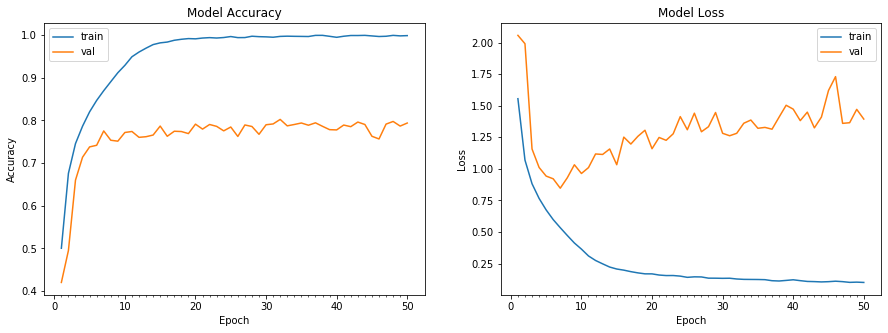

In [24]:

def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy



### There is clear sign of overfitting. Adding droput

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = Dropout(0.1)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = Dropout(0.1)(x)
        x = conv(x)
    return x

In [0]:
version = 2

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 32, 32, 16)   64          conv2d_108[0][0]                 
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 32, 32, 16)   0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 61s 156ms/step - loss: 1.7420 - acc: 0.4773 - val_loss: 2.1353 - val_acc: 0.3991
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 49s 126ms/step - loss: 1.2715 - acc: 0.6296 - val_loss: 1.2544 - val_acc: 0.6232
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 49s 126ms/step - loss: 1.1195 - acc: 0.6765 - val_loss: 1.3978 - val_acc: 0.5799
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 49s 126ms/step - loss: 1.0113 - acc: 0.7137 - val_loss: 1.0301 - val_acc: 0.7043
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 49s 126ms/step - loss: 0.9243 - acc: 0

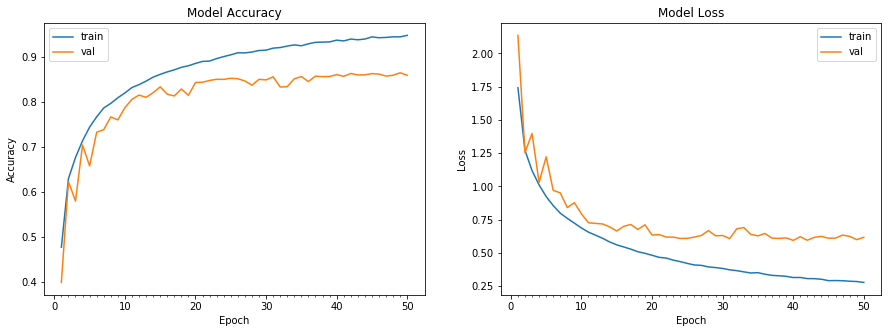

In [35]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

## Highest accuracy is 86.47 after adding droput 
## Experimenting with default LR given in keras documentation

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 45:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
version = 2

In [38]:
!nvidia-smi

Sun Dec  8 13:27:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    25W /  75W |   2431MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [43]:
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 10.8 GB  | Proc size: 4.1 GB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 32, 32, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 32, 32, 16)   64          conv2d_130[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 32, 32, 16)   0           batch_normalization_115[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
Learning rate:  0.001

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 64s 163ms/step - loss: 1.8813 - acc: 0.4526 - val_loss: 1.9921 - val_acc: 0.4099
Epoch 2/50
Learning rate:  0.001

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 50s 127ms/step - loss: 1.4492 - acc: 0.5881 - val_loss: 1.4822 - val_acc: 0.5575
Epoch 3/50
Learning rate:  0.001

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 50s 127ms/step - loss: 1.2639 - acc: 0.6447 - val_loss: 1.3139 - val_acc: 0.6229
Epoch 4/50
Learning rate:  0.001

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 50s 127ms/step - loss: 1.1582 - acc: 0.6796 - val_loss: 1.1932 - val_acc: 0.6629
Epoch 5/50
Learning rate:  0.001

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.

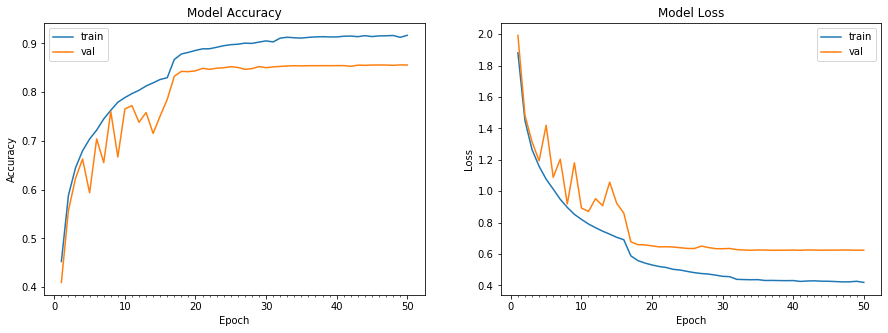

In [41]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

In [0]:
## Highest accuracy after using defalu

## Highest accuracy after using default LR = 85.57.
## So It is better to stick with Rohan's LR
## Trying batch size = 32 with dropout

In [0]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 32, 32, 16)   448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 32, 32, 16)   64          conv2d_152[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 32, 32, 16)   0           batch_normalization_134[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 66s 169ms/step - loss: 1.7463 - acc: 0.4733 - val_loss: 1.8382 - val_acc: 0.4724
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 50s 128ms/step - loss: 1.2934 - acc: 0.6212 - val_loss: 1.5150 - val_acc: 0.5610
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 50s 128ms/step - loss: 1.1265 - acc: 0.6760 - val_loss: 1.2766 - val_acc: 0.6291
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 50s 128ms/step - loss: 1.0226 - acc: 0.7103 - val_loss: 1.0903 - val_acc: 0.6782
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 50s 128ms/step - loss: 0.9351 - acc: 0

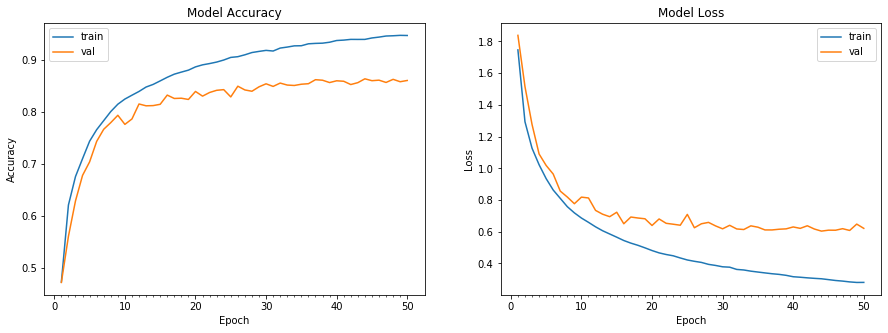

In [45]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

## It seems batch size of 32 has no big effect. The highest max validation accuracy is 86.39 
## Trying 32 filters

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 32
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_174 (Conv2D)             (None, 32, 32, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 32, 32, 32)   128         conv2d_174[0][0]                 
__________________________________________________________________________________________________
activation_153 (Activation)     (None, 32, 32, 32)   0           batch_normalization_153[0][0]    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 112s 287ms/step - loss: 1.8553 - acc: 0.4995 - val_loss: 1.9791 - val_acc: 0.4473
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 93s 238ms/step - loss: 1.3004 - acc: 0.6374 - val_loss: 1.5224 - val_acc: 0.5731
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 93s 238ms/step - loss: 1.1256 - acc: 0.6920 - val_loss: 1.3930 - val_acc: 0.6203
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 93s 238ms/step - loss: 1.0136 - acc: 0.7246 - val_loss: 1.2205 - val_acc: 0.6579
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 93s 238ms/step - loss: 0.9266 - acc: 

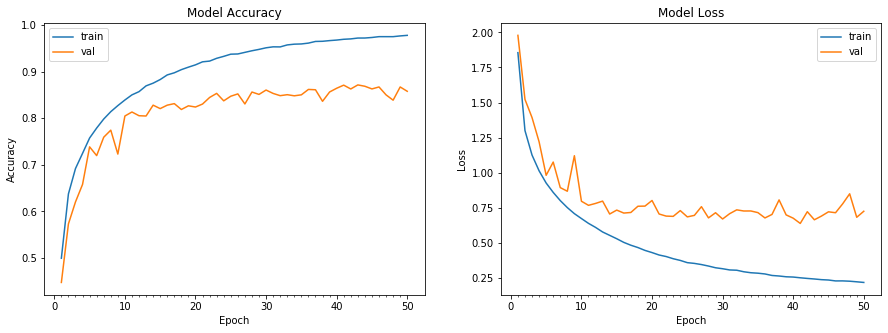

In [48]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

## Trying Leslie Smith LR

In [0]:
learning_rate = []
def lr_schedule(epoch, lr): #Implements cyclical learning rate
  step_size = 2300 #One triangle is completed at the 46th epoch and the learning rate remains the base rate for the rest 4 epochs
  iterations = epoch * 100
  base_lr = .1 #base learning rate
  max_lr = 1.5 #max learning rate
  cycle = np.floor(1+iterations/(2*step_size))
  x = np.abs(iterations/step_size - 2*cycle + 1)
  new_lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
  print((lr, new_lr))
  if(round(lr, 2) <= base_lr and epoch > 1):
    return base_lr 
  else:
    return new_lr

In [52]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_218 (Conv2D)             (None, 32, 32, 32)   896         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, 32, 32, 32)   128         conv2d_218[0][0]                 
__________________________________________________________________________________________________
activation_191 (Activation)     (None, 32, 32, 32)   0           batch_normalization_191[0][0]    
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
(0.0010000000474974513, 0.1)

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 114s 292ms/step - loss: 2.9647 - acc: 0.2208 - val_loss: 2.2918 - val_acc: 0.2163
Epoch 2/50
(0.10000000149011612, 0.16086956521739126)

Epoch 00002: LearningRateScheduler setting learning rate to 0.16086956521739126.
390/390 [==============================] - 93s 240ms/step - loss: 2.1388 - acc: 0.2719 - val_loss: 3.6396 - val_acc: 0.1158
Epoch 3/50
(0.1608695685863495, 0.22173913043478252)

Epoch 00003: LearningRateScheduler setting learning rate to 0.22173913043478252.
390/390 [==============================] - 93s 239ms/step - loss: 2.1940 - acc: 0.2779 - val_loss: 3.7400 - val_acc: 0.1000
Epoch 4/50
(0.22173912823200226, 0.2826086956521738)

Epoch 00004: LearningRateScheduler setting learning rate to 0.2826086956521738.
390/390 [==============================] - 93s 239ms/step - loss: 2.3096 - acc: 0.2651 - val_loss: 2.8805 - val_acc:

KeyboardInterrupt: ignored

### Leslie Smith LR didn't work. May be my base Lr and max lr are wrong

## Resnet20V1 with 32 filters and extra layer of dropout

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = Dropout(0.1)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            x = Dropout(0.1)(x)
        x = conv(x)
        x = Dropout(0.1)(x)
    return x

In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_240 (Conv2D)             (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 32, 32, 32)   128         conv2d_240[0][0]                 
__________________________________________________________________________________________________
activation_210 (Activation)     (None, 32, 32, 32)   0           batch_normalization_210[0][0]    
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 143s 366ms/step - loss: 1.9072 - acc: 0.4753 - val_loss: 1.7910 - val_acc: 0.4889
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 119s 306ms/step - loss: 1.3661 - acc: 0.6151 - val_loss: 1.5520 - val_acc: 0.5752
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 119s 306ms/step - loss: 1.1904 - acc: 0.6680 - val_loss: 1.3042 - val_acc: 0.6277
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 119s 305ms/step - loss: 1.0961 - acc: 0.6981 - val_loss: 1.3799 - val_acc: 0.6149
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 119s 306ms/step - loss: 1.0220 - a

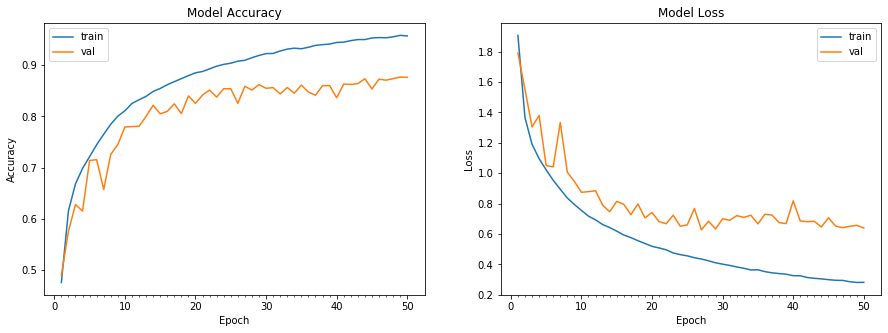

In [55]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

## Repeating the above experiment with batch size =32

In [0]:
def lr_schedule(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
from keras.preprocessing.image import ImageDataGenerator


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)




datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 32),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 callbacks=[LearningRateScheduler(lr_schedule, verbose=1)], #Added Rohan's Learning rate scheduler
                                 validation_data = (x_test, y_test), verbose=1)

                                            
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_262 (Conv2D)             (None, 32, 32, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 32, 32, 32)   128         conv2d_262[0][0]                 
__________________________________________________________________________________________________
activation_229 (Activation)     (None, 32, 32, 32)   0           batch_normalization_229[0][0]    
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=1562, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
1562/1562 [==============================] - 177s 113ms/step - loss: 1.8140 - acc: 0.4660 - val_loss: 1.7710 - val_acc: 0.4418
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
1562/1562 [==============================] - 150s 96ms/step - loss: 1.3952 - acc: 0.5801 - val_loss: 1.5243 - val_acc: 0.5423
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
1562/1562 [==============================] - 149s 96ms/step - loss: 1.2541 - acc: 0.6245 - val_loss: 1.3189 - val_acc: 0.5989
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
1562/1562 [==============================] - 149s 96ms/step - loss: 1.1609 - acc: 0.6571 - val_loss: 1.3099 - val_acc: 0.6147
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
1562/1562 [==============================] - 149s 95ms/step - loss: 1.08